# Load data






In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/My\ Drive/Demokritos-INN

/content/gdrive/My Drive/Demokritos-INN


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

from IPython.core.debugger import set_trace

In [0]:

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [0]:
pip install git+https://github.com/iliaspan/torchsample

In [0]:
import datasets, models

In [0]:
# Load the data table with all 3 Tesla MRI scans from ADNI.
df = datasets.load_data_table_3T()

Loading dataframe for data/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_3T.csv
Found 279 images in table
Filtered out 1 of 279 images because of failed preprocessing
Filtered out 98 of 278 images that were MCI
Final dataframe contains 180 images from 65 patients



In [0]:
df.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,Screen.Diagnosis,Study.ID,Series.ID,filepath
0,15,100_S_0015,bl,CN,2005-10-18,33046,10/31/05,MPR-R; ; N3; Scaled,Baseline,0.0000,NL,2613,8833,data/ADNI/ADNI_2Yr_3T_preprocessed/I33046.nii.gz
1,15,100_S_0015,m12,CN,2006-10-13,63475,10/16/06,MPR-R; ; N3; Scaled,Month 12,11.8033,NL,5490,20311,data/ADNI/ADNI_2Yr_3T_preprocessed/I63475.nii.gz
2,15,100_S_0015,m24,CN,2007-10-11,82551,10/11/07,MPR; ; N3; Scaled,Month 24,23.7049,NL,13281,41463,data/ADNI/ADNI_2Yr_3T_preprocessed/I82551.nii.gz
5,30,023_S_0030,m12,Dementia,2006-10-12,138580,10/12/06,MPR-R; GradWarp; B1 Correction; N3; Scaled,Month 12,11.7049,MCI,10680,20029,data/ADNI/ADNI_2Yr_3T_preprocessed/I138580.nii.gz
6,30,023_S_0030,m24,Dementia,2007-11-13,87493,11/13/07,MPR; GradWarp; B1 Correction; N3; Scaled,Month 24,24.7213,MCI,13696,42714,data/ADNI/ADNI_2Yr_3T_preprocessed/I87493.nii.gz


In [0]:
# Patient-wise train-test-split.
# Select a number of patients for each class, put all their images in the test set 
# and all other images in the train set. This is the split that is used in the paper to produce the heatmaps.
test_patients_per_class = 20

patients_AD = df[df['DX'] == 'Dementia']['PTID'].unique()
patients_CN = df[df['DX'] == 'CN']['PTID'].unique()
#patients_CN = filter(lambda p: p not in patients_AD, patients_CN)  # patients that have both a CN and an AD scan should belong to the AD group


In [0]:
patients_AD_train, patients_AD_test = train_test_split(patients_AD, test_size=test_patients_per_class, random_state=0)
patients_CN_train, patients_CN_test = train_test_split(patients_CN, test_size=test_patients_per_class, random_state=0)

In [0]:
patients_train = np.concatenate([patients_AD_train, patients_CN_train])
patients_test = np.concatenate([patients_AD_test, patients_CN_test])

In [0]:
train_dataset, test_dataset = datasets.build_datasets(df, patients_train, patients_test)

         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         180       88       92          65       37       28
Train        73       48       25          25       17        8
Val         107       40       67          40       20       20

Calculating mean and std for normalization:


0.0 629.094449098244 None None


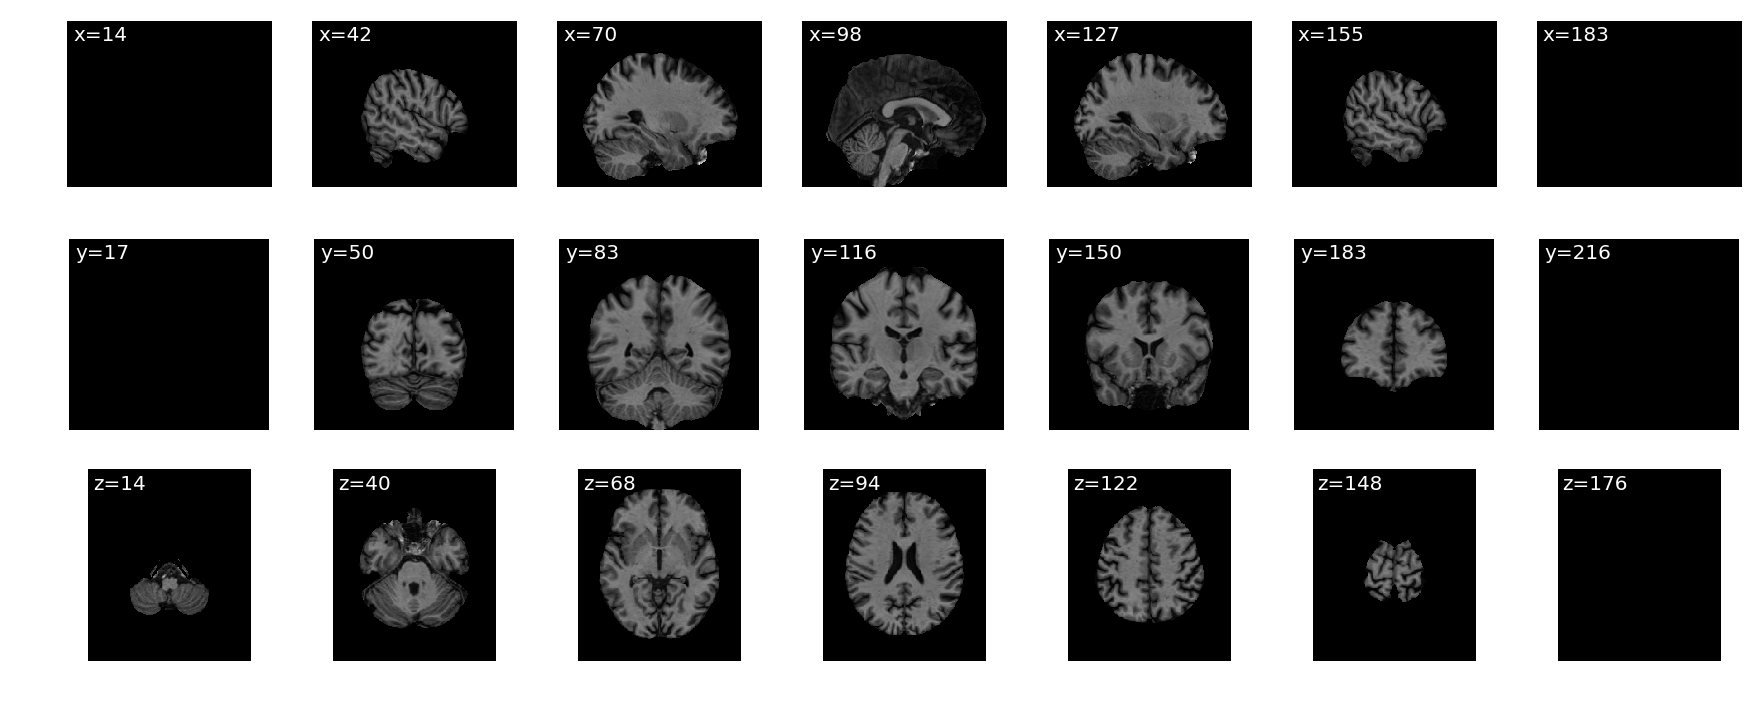

In [0]:
# Plot one MRI scan from the dataset, first without normalization...
i = 0
utils.plot_slices(train_dataset.get_raw_image(i))

tensor(-2.0476) tensor(2.8597) None None


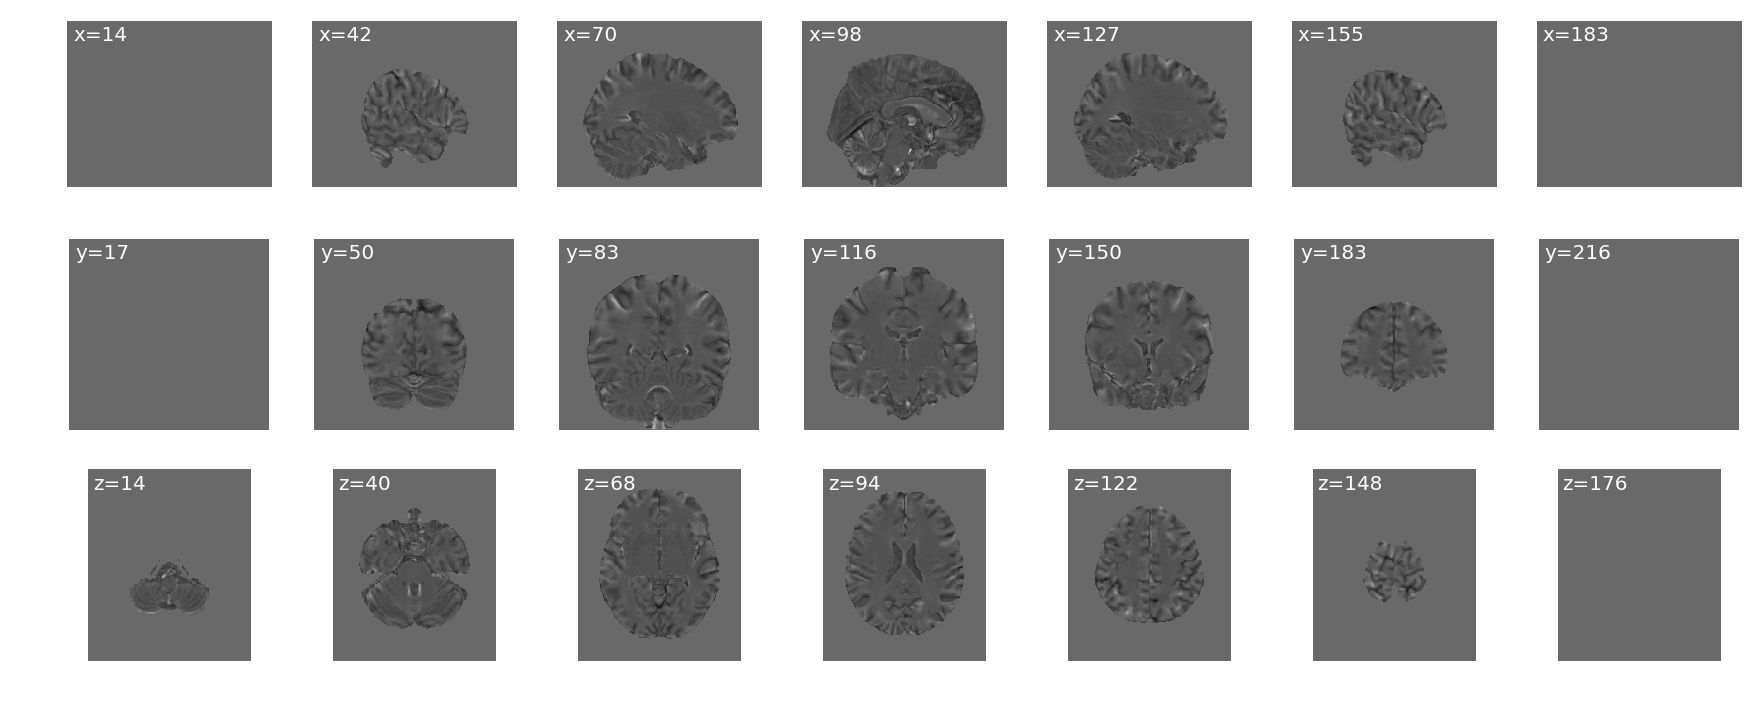

In [0]:
# ... and then with normalization, i.e. the way the network sees it.
utils.plot_slices(train_dataset[i][0][0])

In [0]:
train_loader, test_loader = datasets.build_loaders(train_dataset, test_dataset)

# Create model and train






In [0]:
# This creates the model from the paper in pytorch, and wraps it in a `trainer` via torchsample. 
net, trainer, cuda_device = models.build_model()

Moved network to GPU


In [0]:
models.train_model(trainer, train_loader, test_loader, cuda_device, num_epoch=10)

Epoch 1/10:   0%|          | 0/19 [00:00<?, ? batches/s]/content/gdrive/My Drive/Demokritos-INN/models.py:198: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return super(CategoricalAccuracyWithLogits, self).__call__(F.softmax(y_pred), y_true)
Epoch 1/10: 100%|██████████| 19/19 [02:53<00:00,  9.07s/ batches, loss=0.6694, acc=60.27]/usr/local/lib/python3.6/dist-packages/torchsample/modules/module_trainer.py:658: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(input_batch, volatile=volatile), Variable(target_batch, volatile=volatile, requires_grad=False)
Epoch 1/10: : 20 batches [03:37, 21.40s/ batches, loss=0.272, val_loss=0.718, val_acc=37.38, acc=60.27]                
Epoch 2/10: : 20 batches [03:32, 19.70s/ batches, loss=0.207, val_loss=0.77, val_acc=37.38, acc=65.75]                
Epoch 3/10: : 20 batches [03:34, 20.15s/ batches, loss=0.406, 

In [0]:
utils.plot_learning_curve(trainer.history)

In [0]:
models.calculate_roc_auc(trainer, test_loader, cuda_device)

# Save/load model






In [0]:
torch.save(net, 'output/models/softmax-output.pt')
torch.save(net.state_dict(), 'output/models/softmax-output_state-dict.pt')

In [0]:
net = models.ClassificationModel3D()
net.load_state_dict(torch.load('output/models/softmax-output_state-dict.pt'))

<All keys matched successfully>

In [0]:
if torch.cuda.is_available():
    net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

Moved network to GPU


# K-Fold Cross Validation






In [ ]:
# This is used to report the accuracy and ROC in the paper. 
# We take the metrics on the test fold after 20 epochs, regardless of how good they are or if they've been better during an earlier epoch. 

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

patients_all = df['PTID'].unique()

normalize = True
num_epoch = 20

# Split patients into k folds.
for i, (indices_train, indices_test) in enumerate(kfold.split(patients_all)):
    print('{}-fold CV - Split {}:'.format(kfold.n_splits, i+1))
    print()

    print('Preparing datasets...')
    patients_train, patients_test = patients_all[indices_train], patients_all[indices_test]
    train_dataset, test_dataset = datasets.build_datasets(df, patients_train, patients_test, normalize=normalize)
    train_loader, test_loader = datasets.build_loaders(train_dataset, test_dataset)
    
    print('Building model and trainer...')
    net, trainer, cuda_device = models.build_model()
    
    print('Starting training...')
    models.train_model(trainer, train_loader, test_loader, cuda_device, num_epoch=num_epoch)

    utils.plot_learning_curve(trainer.history)
    
    print('Evaluating ROC...')
    roc_auc = models.calculate_roc_auc(trainer, test_loader, cuda_device)
    print('ROC AUC:', roc_auc)

    print()
    print('-'*80)
    print()